# PID Controller

Python port of https://github.com/br3ttb/Arduino-PID-Library.

![Block Diagram](figures/PID_en.svg)

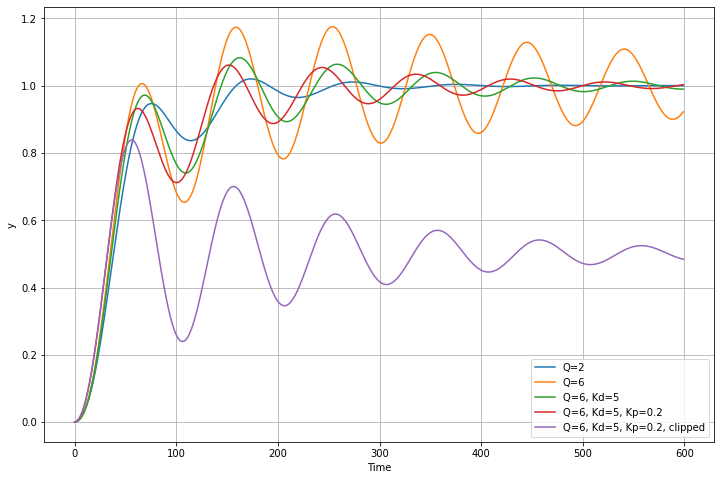

In [7]:
%%host

def const(x): return x

from array import array
import numpy as np

_R     = const(0)  # setpoint            
_U     = const(1)  # PID output             
_Y     = const(2)  # Last plant output        
_SUM   = const(3)  # Integral term       
_TS    = const(4)  # sampling interval [s]
_KP    = const(5)  # proportional term
_KI    = const(6)  # scaled by *Ts
_KD    = const(7)  # scaled by /Ts
_U_MIN = const(8)  # minimum PID output (anti-windup)
_U_MAX = const(9)  # maximum PID output (anti-windup)

class PID:
    
    def __init__(self, Ts, kp, ki, kd, u_min=-float('inf'), u_max=float('inf')):
        self.auto = True
        self.state = array('f', [
            0,     # r (setpoint)
            0,     # u (PID output)
            0,     # y (plant output)
            0,     # (integral sum for P-term calculation)
            Ts,    # sampling interval
            kp,    # kp
            ki*Ts, # ki scaled
            kd/Ts, # kd scaled
            u_min, # u_min
            u_max, # u_max
        ])
        self.setpoint = 1 # default is step response
        
    def update(self, y):
        """compute new PID output u from plant output y"""
        if not self.auto: return
        # local "cache"
        s = self.state
        u_min = s[_U_MIN]
        u_max = s[_U_MAX]
        err = s[_R] - y
        s[_SUM] += np.clip(s[_KI] * err, u_min, u_max)   # integrator state
        u = np.clip(s[_KP] * err + s[_SUM] - s[_KD] * (y - s[_Y]), u_min, u_max)
        s[_Y] = y  # save last y
        return u

    @property
    def setpoint(self):
        return self.state[_R]
    
    @setpoint.setter
    def setpoint(self, setpoint):
        self.state[_R] = setpoint
        
    @property
    def kp(self):
        return self.state[_KP]
        
    @property
    def ki(self):
        return self.state[_KI] / self.Ts
        
    @property
    def kd(self):
        return self.state[_KD] * self.Ts
        
    @kp.setter
    def kp(self, kp):
        self.state[_KP] = kp
        
    @kp.setter
    def ki(self, ki):
        self.state[_KI] = ki * self.Ts
        
    @kp.setter
    def kd(self, kd):
        self.state[_KD] = kd / self.Ts
        
    @property
    def Ts(self):
        return self.state[_TS]
    
    @property
    def auto_mode(self):
        return self.auto
    
    @auto_mode.setter
    def auto_mode(self, auto):
        if not self.auto and auto:
            # switched from manual to auto mode
            state = self.state
            state[_INT] = np.clip(state[_Y], state[_U_MIN], state[_U_MAX])
        self.auto = auto

    def set_limits(self, u_min, u_max):
        """PID output limits"""
        self.state[_U_MIN] = u_min
        self.state[_U_MAX] = u_max
        
class Biquad:
    
    def __init__(self, fs, fc, Q):
        import math
        K = math.tan(math.pi*fc/fs)
        K2 = K*K
        self.b0 = K2
        self.b1 = 2*K2
        self.b2 = K2
        self.a0 = K2+K/Q+1
        self.a1 = 2*(K2-1)
        self.a2 = K2-K/Q+1
        
        self.x1 = 0   # x[n-1]
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def update(self, x):
        y = (self.b0*x + self.b1*self.x1 + self.b2*self.x2 
             - self.a1*self.y1 - self.a2*self.y2) / self.a0
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

class BuildArray:
    """Build np array iteratively."""
    
    def __init__(self, cols, max_rows=10000):
        """Number of column & max number of rows"""
        self.rows = 0
        self.cols = cols
        self.array = np.zeros((max_rows, cols))
        
    def add_row(self, v):
        """v is a vector of length cols"""
        self.array[self.rows] = v
        self.rows += 1
        
    def resize(self):
        """Resize to actual size. Now add_row can't be called anymore."""
        self.array.resize((self.rows, self.cols))
        return self.array

    
# simlation

specs = [
    [ Biquad(1, 0.01, 2), PID(1, 0.1, 0.02, 3), 'Q=2'],
    [ Biquad(1, 0.01, 6), PID(1, 0.1, 0.02, 3), 'Q=6'],
    [ Biquad(1, 0.01, 6), PID(1, 0.1, 0.02, 5), 'Q=6, Kd=5'],
    [ Biquad(1, 0.01, 6), PID(1, 0.2, 0.02, 5), 'Q=6, Kd=5, Kp=0.2'],
    [ Biquad(1, 0.01, 6), PID(1, 0.2, 0.02, 5, -0.5, 0.5), 'Q=6, Kd=5, Kp=0.2, clipped'],
]

N = 600  # data points
cols = len(specs)

data = BuildArray(cols+1, max_rows=N)
y = [0] * cols

for t in range(N):
    row = [0]*(cols+1)
    row[0] = t
    for i, spec in enumerate(specs):
        biquad, pid, legend = spec
        row[i+1] = y[i] = biquad.update(pid.update(y[i]))
    data.add_row(row)

import matplotlib.pyplot as plt

a = data.array
t = a[:, 0]
y = a[:, 1:]
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(t, y)
plt.xlabel('Time')
plt.ylabel('y')
plt.grid()
plt.legend([row[2] for row in specs]);

Text(0, 0.5, 'step response')

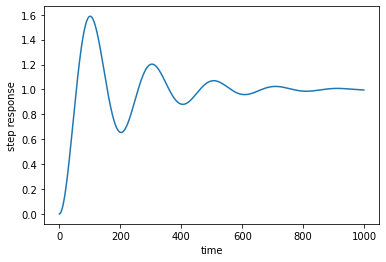

In [51]:
%%host

# https://www.earlevel.com/main/2003/03/02/the-bilinear-z-transform/
# https://en.m.wikipedia.org/wiki/Digital_biquad_filter

class Biquad:
    
    def __init__(self, fs, fc, Q):
        import math
        K = math.tan(math.pi*fc/fs)
        K2 = K*K
        self.b0 = K2
        self.b1 = 2*K2
        self.b2 = K2
        self.a0 = K2+K/Q+1
        self.a1 = 2*(K2-1)
        self.a2 = K2-K/Q+1
        
        self.x1 = 0   # x[n-1]
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def update(self, x):
        y = (self.b0*x + self.b1*self.x1 + self.b2*self.x2 
             - self.a1*self.y1 - self.a2*self.y2) / self.a0
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

bq = Biquad(1, 0.005, 3)
ba = BuildArray(2)

x = 1
for i in range(1000):
    ba.add_row([i, bq.update(x)])
    
ba.resize()

import matplotlib.pyplot as plt

a = ba.array
t = a[:, 0]
y = a[:, 1]
plt.plot(t, a[:, 1:4])
plt.xlabel("time")
plt.ylabel("step response")